In [1]:
# ref detector: https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
# ref rotation: https://www.kaggle.com/code/gpiosenka/align-crop-resize-save-images-using-mtcnn

import os
import sys

sys.path.append('../tflow/mtcnn')

import cv2
import json
import numpy as np
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
from imutils.paths import list_images
from scipy.spatial.distance import euclidean
from utils import load_image, align, crop_image, rotate_bound

In [2]:
# 1. obj detection
# obj: usar mtcnn para detectar regiones de interes y guardarlas en un archivo json
# este preprocesado ayudará en las siguientes etapas.

# 2. make splits
# make splits for each dataset conjunction
# extra: separate them into jsons/txt
# - flickr vs flickr
# - splunk vs splunk
# - flickr vs splunk
# - splunk vs flickr


datasets = {
    'flickr': '/media/choppy/WD_BLACK/datasets/FLICKR',
    'splunk': '/media/choppy/WD_BLACK/datasets/Splunk',
}

verbose = False

In [3]:
# instance detector
# TODO: explore min and max face size of detector inference
detector = MTCNN(min_face_size=600)

2022-09-28 11:53:42.860975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 11:53:43.135996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 11:53:43.136611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 11:53:43.137589: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

doing inference over 14000 images from FLICKR


flickr:   0%|                                                                                                                                                                            | 0/14000 [00:00<?, ?it/s]2022-09-28 11:53:44.990586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-09-28 11:53:45.546684: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 11:53:45.547072: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 11:53:45.547089: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-28 11:53:45.547452: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-28 11:53:45.547493: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Fai

flickr:   0%|▏                                                                                                                                                                | 19/14000 [00:33<6:48:02,  1.75s/it]


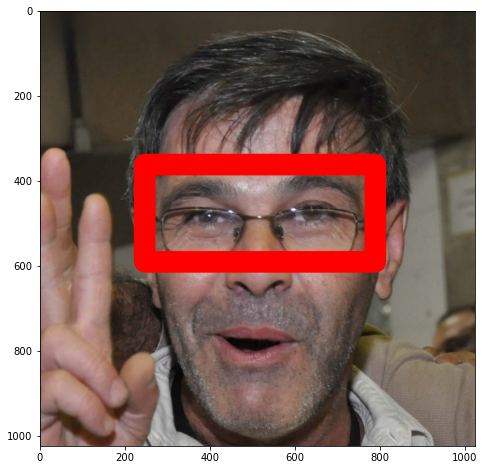

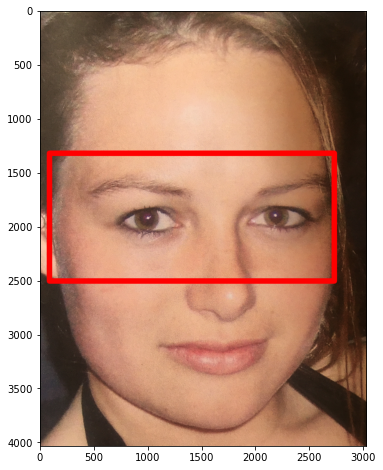

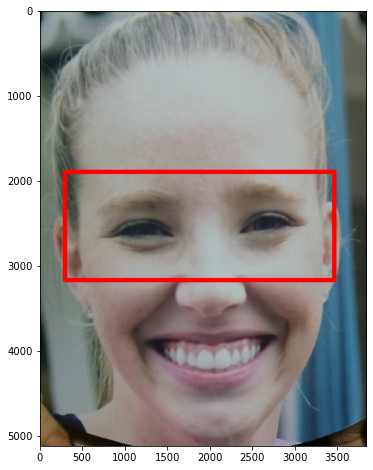

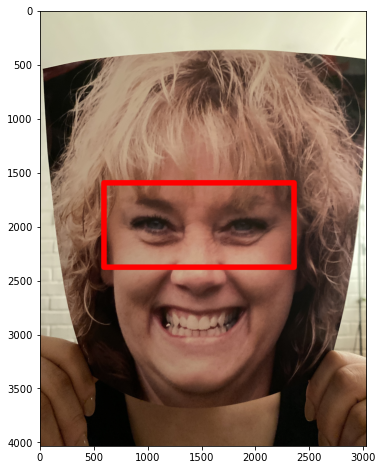

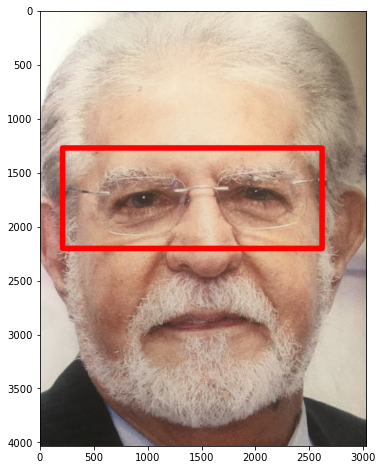

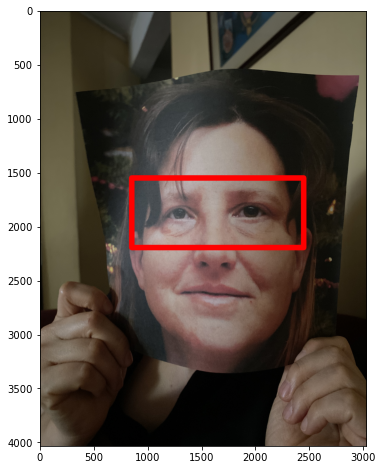

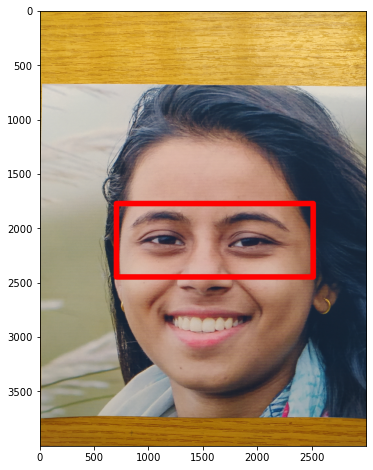

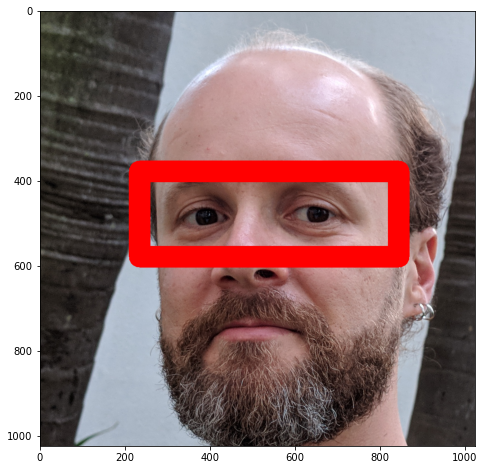

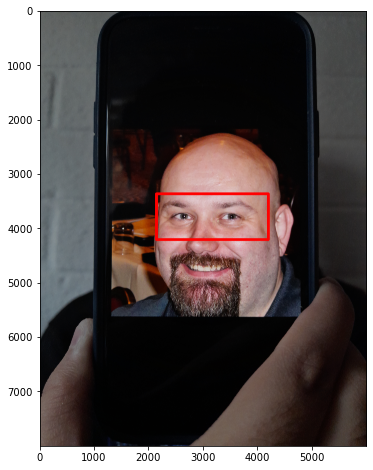

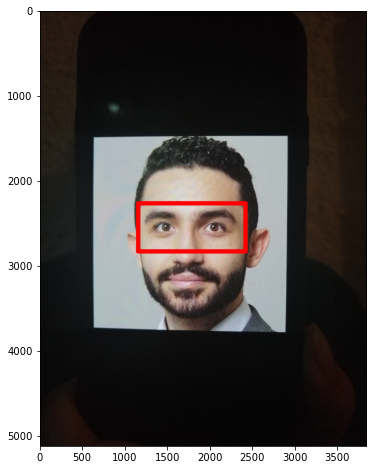

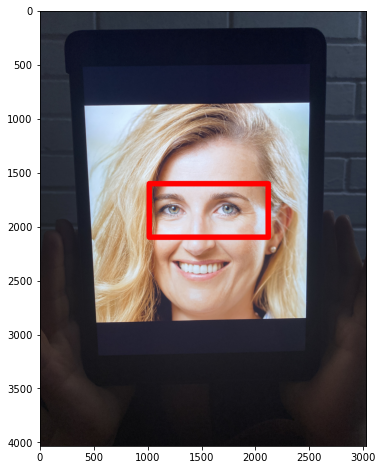

In [4]:
# obj: usar mtcnn para detectar regiones de interes y guardarlas en un archivo json

i = 0

for dst_key in datasets:
    ds_dir = datasets.get(dst_key)
    # images = list(sorted([*list_images(ds_dir)], reverse=True))
    images = [*list_images(ds_dir)]
    np.random.shuffle(images)
    db_name = os.path.basename(ds_dir)
    json_data = []
    
    print(f"doing inference over {len(images)} images from {db_name}")
    
    for imdir in tqdm(images, desc=dst_key):
        img = load_image(imdir)
        detections = detector.detect_faces(img)
        img_path_dir = imdir.split(db_name)[-1][1:]
        
        # find best detection and biggest bbox
        biggest = 0
        best_det = None
        if len(detections) > 1:
            if verbose: print(f'more than one face detected in img: {imdir}, but only the biggest is stored')
            for det in detections:
                box = det['box']            
                # calculate the area in the image
                area = box[2] * box[3]
                if area > biggest:
                    biggest = area
                    bbox = box
                    best_det = det
        elif len(detections) == 1:
            best_det = detections[0]
        else:
            if verbose: print(f'no predictions for {imdir}, please check.')
            continue
        
        # add periocular as extra bbox on detection
        
        
        # continue working with best_det dict
        # construct dict to store json data
        json_data.append({
            'image_dir': os.path.join(db_name, img_path_dir),
            'mtcnn-inference': best_det, 
        })
        
        red = [255, 0, 0]
        bbox = best_det['box']
        nose = best_det.get('keypoints')['nose']
        left_eye, right_eye = best_det.get('keypoints')['left_eye'], best_det.get('keypoints')['right_eye']
        dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
        mean_dst = np.mean([dst1, dst2]).astype(np.uint16)

        periocular = img.copy()

        # face + distance
        periocular = cv2.rectangle(periocular, (bbox[0], left_eye[1]-int(mean_dst*0.6)), (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.6)), color=red, thickness=50)
        
        plt.figure(figsize=(10, 8))
        plt.imshow(periocular)
        
        i += 1
        
        if i == 20:
            break
    
    # store json data as db-name.json
    json.dump(json_data, open(db_name+'.json', 'w'))
    break

In [5]:
# nose = best_det.get('keypoints')['nose']
# left_eye, right_eye = best_det.get('keypoints')['left_eye'], best_det.get('keypoints')['right_eye']

In [6]:

red = [255, 0, 0]
periocular = img.copy()
periocular = cv2.circle(periocular, left_eye, radius=100, color=red, thickness=-1)
periocular = cv2.circle(periocular, right_eye, radius=100, color=red, thickness=-1)
periocular = cv2.circle(periocular, nose, radius=100, color=red, thickness=-1)
plt.figure(figsize=(10, 8))
plt.imshow(periocular)

In [7]:
# para hacer zona periocular

# distancia entre cada ojo y agregar 20% de margen izq/der
# para altura, triangular distancia desde los ojos hasta la nariz y estimar un 20-30%


# calcular distancia euclideana entre ambos puntos (nariz y ambos ojos) y calcular promedio
# a ese promedio aplicarle 20-30% de margen

In [8]:
dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
dst1, dst2

(776.2377213199575, 668.5962907465162)

In [9]:
mean_dst = np.mean([dst1, dst2]).astype(np.uint16)
mean_dst, mean_dst * 1.25, mean_dst * 0.75

(722, 902.5, 541.5)

In [10]:
bbox = best_det['box']

periocular = img.copy()

# face
# periocular = cv2.rectangle(periocular, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color=red, thickness=50)

# periocular
# periocular = cv2.circle(periocular, nose, radius=250, color=red, thickness=-1)

# periocular
# periocular = cv2.rectangle(periocular, (int(left_eye[0]*.75), int(left_eye[1]*0.80)), (int(right_eye[0]*1.235), int(right_eye[1]*1.15)), color=red, thickness=50)

# face + distance
periocular = cv2.rectangle(periocular, (bbox[0], left_eye[1]-int(mean_dst*0.75)), (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.5)), color=red, thickness=50)

plt.figure(figsize=(10, 8))
plt.imshow(periocular)

In [11]:
# process all images here